# Gaussian Processes for regression

This post talks about a neat way to do regression using a Gaussian Process, or a huge multivariate Gaussian that represents a distribution over functions. Given some observations from a function I might not know much about, I'll end up with an estimated function with nice error bars.

First I sample some points from some fake function to be my observation. Gaussian Processes can work with more arbitrary functions, so here's a fun-looking function. The red line is the underlying function. The black x's are samples with added noise.

![](images/2018-05-18-observations.png)

Below is the result of the regression. The black x's are the same observations as above and the black line is the same function as above. This time, the blue line is the estimate of the function and the blue shaded area is a measure of uncertainty.

![](images/2018-05-18-prediction.png)

This post is based on [Iain Murray's course notes on Gaussian processes](http://www.inf.ed.ac.uk/teaching/courses/mlpr/2017/notes/w7c_gaussian_processes.html), and parts are from [Murray's demo](http://www.inf.ed.ac.uk/teaching/courses/mlpr/2017/notes/gp_altdemo.py). It also seems to follow Chapter 19 of [Bayesian Reasoning and Machine Learning](http://www0.cs.ucl.ac.uk/staff/d.barber/brml/).
I also thought [this video](https://www.youtube.com/watch?v=Jv25sg-IYHU) was useful.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# helper functions you can skip over :D
SAVE = True
def maybe_save_plot(filename):
    if SAVE:
        plt.tight_layout()
        plt.savefig('images/' + filename, bbox_inches="tight")

## Generating Data

First I'll generate some fake observations. I'll sample $N = 20$ points from an underlying function $f$ and add a little noise to get $y$.

### Sample $N$ points

One special detail with sampling the points is that I choose the $x$ values by making a range of numbers representing the $x$ axis of the points I want to plot. Then I choose $N$ of those to be the observations. I split the range into those $N$ points for observations and the remaining points. This will be important when I build the giant multivariate Gaussian.

As a result, `observed_xs` will be of size $N = 20$, and `unobserved_xs` will be of size $500 - N = 480$.

In [2]:
N = 20  # How many points I'll sample

# Make a range of numbers I could plot
all_xs = np.linspace(-10, 10, 500)[:, None]


def split_up_xgrid(xs, N):
    '''Choose N random points from raw_xs, return those N points and 
    the remaining points
    '''
    # Thanks https://stackoverflow.com/a/32726407
    point_i = np.full(xs.shape, False, bool)
    a = np.random.choice(point_i.shape[0], N, replace=False)
    point_i[a] = True
    return xs[point_i], xs[~point_i]


# Select N of those to be the observations and keep the rest around for later
observed_xs, unobserved_xs = split_up_xgrid(all_xs, N)

### Generating toy observations

Now I'll make some observed points $y$, which I assume come from a function $f$ with some added noise. So $y = f(x) + \epsilon$ where $\epsilon \sim \mathcal{N}(0, \sigma_w^2)$. 

The code below doesn't have much to do with Gaussian processes and usually you'd be working with real data rather than fake observations, so feel free to skip it. You can also check out [my previous post](2018-01-08-bayesian-linreg-sample.ipynb) to learn more about generating demo data.

I create the true function $f$, compute the values of $f$ at the $N$ data points from above, and add Gaussian noise $\epsilon \sim \mathcal{N}(0, \sigma_w)$ to make the observations $y$.

In [3]:
sigma_w = 0.1  # This is some noise added to the sampled points

# toy function

# I'll make some funky-looking function by doing a linear combination of
# logistic sigmoids.

# don't mind me, this is just to help build f
f_params = [
    (5, 0.5, -1),
    (-2, 5, 1),
    (-4, 3, 10),
]

# I'm dealing with a single input, so I'll explicitly write out x and b
def sig(x, w, b): return 1 / (1 + np.exp(-(w * x + b)))

# This is what we've been waiting for!
def f(x): 
    return np.sum(
        ((c * sig(x, w, b)) for (c, w, b) in f_params)
    )

# observed_ys are given by the function plus some noise
observed_ys = f(observed_xs) + (sigma_w * np.random.randn(observed_xs.shape[0]))

### Plotting

Here I plot the function $f$ and the observed $y$.

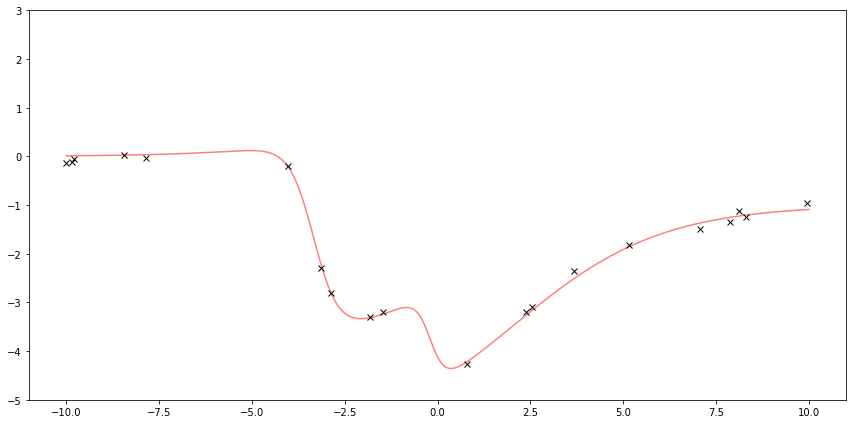

In [4]:
plt.clf()

plt.figure(figsize=(12, 6))
plt.plot(all_xs, f(all_xs), '-r', alpha=0.5)
plt.plot(observed_xs, observed_ys, 'xk')

plt.ylim(-5, 3)

maybe_save_plot('2018-05-18-observations')
plt.show()

Except for the interesting way of choosing the $N$ observed x values, none of this is specific for regression using Gaussian Processes.

## Gaussian Processes

I'll make a huge multivariate Gaussian distribution with all possible points I care about. In this case, the only points I care about are the 500 points in `all_xs`. This is an interesting way to simplify this problem! The justification is that when I'm done, I'm only going to plot a finite number of points anyway, and because of the nature of Gaussians, I can do this ignoring the other infinite points in that range. (It's also a little funny because a "Gaussian Process" is based on having an infinite variable Gaussian, but we quickly turn around and make it finite again!)

To define the 500-dimensional multivariate Gaussian distribution, I'll need the mean for each dimension, a vector of size $500\times 1$, and the covariance matrix, a matrix of size $500\times 500$*. For example, one of the rows in the mean vector will represent the mean at $x = 0.00$, another will be the mean at $x = 0.01$. 

*The size of this covariance matrix is one of the reasons why GP's tend to only be used for small datasets.

### Initializing the means and covariances

The means and covariances of $p(\textbf f, \textbf g)$ don't depend on the observations, and only depend on hyperparameters. The observations only come in when I compute $p(\textbf f \mid \textbf g)$.

I'll set the means $\textbf{a}$ and $\textbf{b}$ to be 0.

The covariance matrix is probably the most important part.

When I increase an element in the covariance matrix, it means the corresponding points are more likely to have similar values. This is how we get a smooth function instead of random points.

For example, adjusting the value representing `0.15` vs `0.40` in the covariance matrix corresponds affects how close they are together. Given a set value for `0.15`, if the covariance is high, `0.40` will usually be assigned a similar number. If the covariance is low, `0.40` can be assigned different values. The below two images try to visualize this, inspired by [this video](https://www.youtube.com/watch?v=Jv25sg-IYHU).

![](images/2018-05-18-cov-element.png)

![](images/2018-05-18-cov-similarity.png)


The elements of the covariance matrix are typically populated using a kernel function, such as the RBF kernel function:

$$K[x_i][x_j] = \sigma_f^2\exp\left(-\frac{||x_i - x_j||^2}{2\ell^2}\right)$$

There are other kernel functions, but they are required to create a valid covariance matrix.

In [5]:
def k(xi, xj, ell, sigma_f):
    return sigma_f**2 * np.exp(-((xi - xj)/ell)**2/2)


def create_K(x_i, x_j, ell, sigma_f):
    # This is a slow function, for a faster implementaiton, see
    # http://www.inf.ed.ac.uk/teaching/courses/mlpr/2017/notes/gp_minimal.py
    K = np.zeros((x_i.shape[0], x_j.shape[0]))
    for i in range(x_i.shape[0]):
        for j in range(x_j.shape[0]):
            K[i][j] = k(x_i[i], x_j[j], ell, sigma_f)
    return K

One way that's fun to visualize this is a heatmap. The brighter points have a higher covariance value. This shows that points close to each other have a higher covariance, and those farther away have a lower one.

This can show the impact of $\ell$. A larger $\ell$ means that points farther away from each other are considered more related than if we had used a smaller $\ell$.

Changes in $\sigma_f$ will change how large each value is.

In [6]:
def plot_K(ell, sigma_f, title):
    size = 16
    x = np.linspace(-4, 4, size)
    K = create_K(x, x, ell, sigma_f)
    
    # hardcode a max value so diff sigmas are obvious
    plt.imshow(K, cmap='hot', interpolation='nearest', vmin=0, vmax=100)
    plt.title(title)

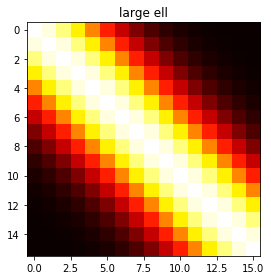

In [7]:
plot_K(2, 10, 'large ell')
maybe_save_plot('2018-05-18-large-ell')
plt.show()

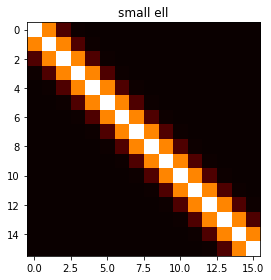

In [8]:
plot_K(0.5, 10, 'small ell')
maybe_save_plot('2018-05-18-small-ell')
plt.show()

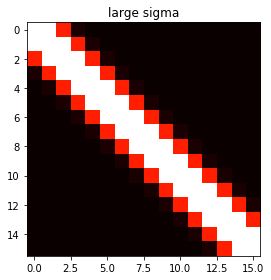

In [9]:
plot_K(0.5, 20, 'large sigma')
maybe_save_plot('2018-05-18-large-sigma')
plt.show()

### Prior

I can plot what the Gaussian Process prior thinks of the world before it's given any data.

To plot this, I look at the marginal distribution of this multivariate Gaussian for just one dimension, say for $x = 0.01$. I end up with the univariate Gaussian I know and love. I'll use this Gaussian's mean as my estimate for that point. I can also use its standard deviation to mark a region of uncertainty. Then I'll repeat this for all 500 points in `all_xs`, getting 500 univariate Gaussians, and plotting the mean and standard deviations of them.

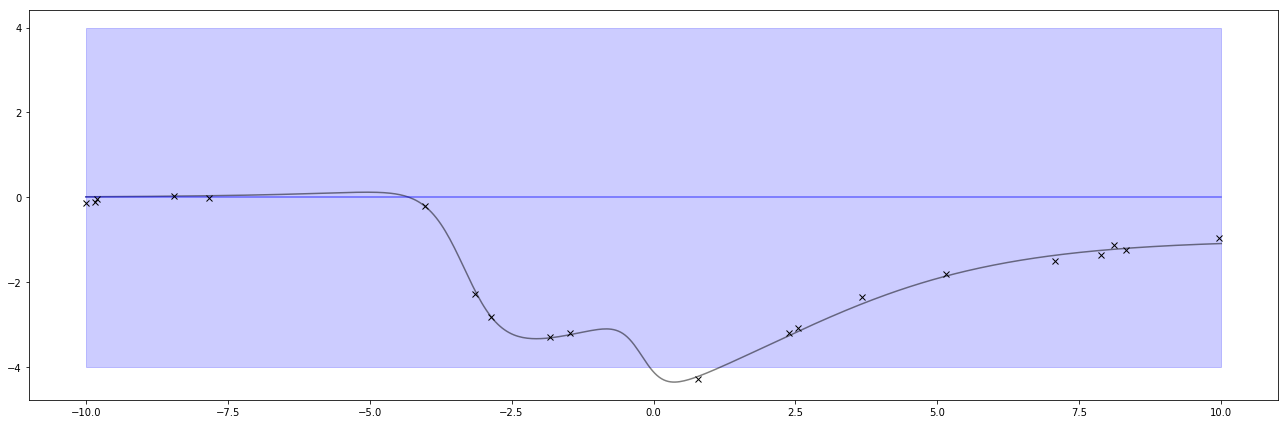

In [10]:
ell = 10
sigma_f = 2

mu = np.zeros((all_xs.shape[0],))

# compute the cov! 
cov = create_K(all_xs, all_xs, ell=ell, sigma_f=sigma_f)
stds = np.sqrt(np.diagonal(cov))

bottom = (mu[:, None] - 2 * stds[:, None])[:, 0]
top = (mu[:, None] + 2 * stds[:, None])[:, 0]

plt.figure(figsize=(18, 6))

plt.plot(all_xs, f(all_xs), '-k', alpha=0.5)
plt.plot(all_xs, mu, '-b', alpha=0.5)
plt.fill_between(all_xs[:, 0], bottom, top, color='blue', alpha=0.2)
plt.plot(observed_xs, observed_ys, 'xk')
maybe_save_plot('2018-05-18-prior-beliefs')
plt.show()

## Given observations

Now I can incorporate the observations. I'll split up the multivariate Gaussian's dimensions into the dimensions corresponding to my observations, and those corresponding to the points I want to know. So if $\textbf{f}$ represents the points I don't know and $\textbf{g}$ represents the points I do know, then I can rearrange my points and write a big matrix like

$$p(\textbf{f}, \textbf{g}) = 
\mathcal N\left(
\left[\begin{array}{c} \textbf{f} \\ \textbf{g} \end{array}\right];
\left[\begin{array}{c}\textbf{a} \\ \textbf{b}\end{array}\right], 
\left[\begin{array}{cc}A & C^{\top} \\ C & B\end{array}\right]
\right) $$

where $\textbf a$ and $\textbf b$ are vectors, and $A$, $B$, and $C$ are matrices. I think it's a little useful to imagine at the shapes of the covariance matrix like this:

![](images/2018-05-18-cov.png)

The full covariance matrix is filled with the values dictated by the kernel function, and so are the $A$, $B$, and $C$. 

Now let's predict the unobserved values given the observed values! To do this, I compute the posterior $p(\textbf{f} \mid \textbf{g})$, or the probability distribution of the unobserved given the values of the observed points. It turns out Gaussians have a convenient closed-form solution to this given by:

$$p(\textbf{f} \mid \textbf{g}) = \mathcal N(\textbf{f}; \textbf{a} + CB^{-1}(\textbf{g} - \textbf{b}), A - CB^{-1}C^{\top}).$$

Since I'm assuming $\textbf{a}$ and $\textbf{b}$ are 0, this is just

$$p(\textbf{f} \mid \textbf{g}) = \mathcal N(\textbf{f}; CB^{-1}\textbf{g}, A - CB^{-1}C^{\top})$$

So all I need to do is compute the big vector of $500 - N$ values that represent the mean $\textbf{a} + CB^{-1}(\textbf{g} - \textbf{b})$, and the diagonal of the covariance, $A - CB^{-1}C^{\top}$ to get the variances.

There's one catch: I'm assuming my observations also included some noise $\sigma_y$, so I need to add that to the variances $A$.

To summarize:
 - Build $A$, $B$, and $C$ using the kernel function. Add noise to $A$.
 - Compute the $500 - N$ values that represent the mean and the $500 - N \times 500 - N$ matrix representing covariance.
 - Use this to plot the estimate and error bars

In [11]:
def posterior(unobserved_xs, observed_xs, observed_ys, ell, sigma_f):
    A = create_K(unobserved_xs, unobserved_xs, ell, sigma_f)
    B = create_K(observed_xs, observed_xs, ell, sigma_f) + (sigma_w ** 2 * np.identity(N))
    C = create_K(unobserved_xs, observed_xs, ell, sigma_f)
    
    # compute mu
    mu = C @ np.linalg.solve(B, observed_ys)
    
    # compute the cov
    cov = A - C @ np.linalg.solve(B, C.T)
    
    return mu, cov

def upper_lower_bounds(mu, cov):
    '''returns the lower and upper bounds based on stdevs
    
    mu: shape (x,)
    cov: shape (x, x)
    '''
    # compute error bars based on variance.
    stds = np.sqrt(np.diagonal(cov))
    
    # forcing everything to be the right size
    return (mu[:, None] - 2 * stds[:, None])[:, 0], (mu[:, None] + 2 * stds[:, None])[:, 0]

And now I'll plot it!

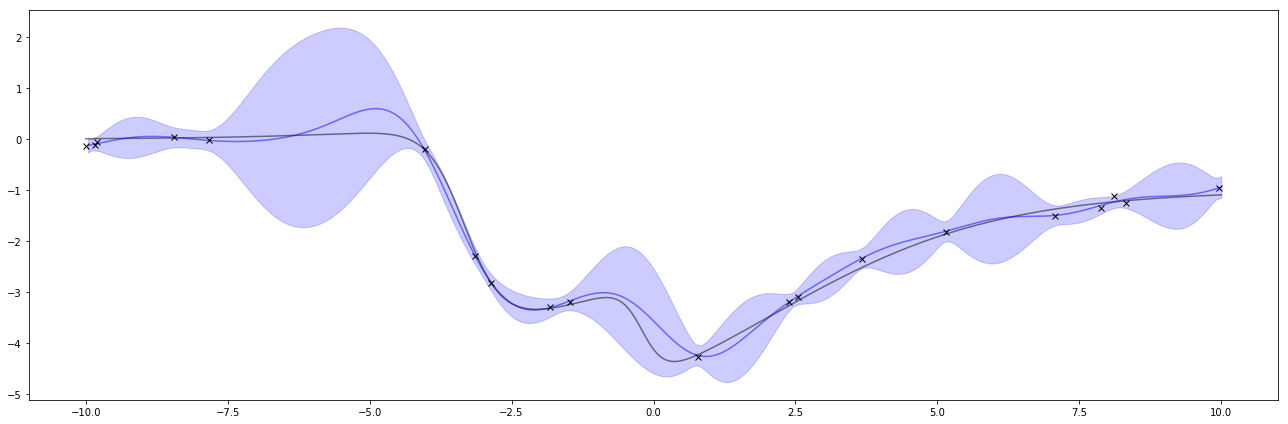

In [12]:
mu, cov = posterior(unobserved_xs, observed_xs, observed_ys, ell=1, sigma_f=1)
bottom, top = upper_lower_bounds(mu, cov)

plt.figure(figsize=(18, 6))

plt.plot(all_xs, f(all_xs), '-k', alpha=0.5)
plt.plot(unobserved_xs, mu, '-b', alpha=0.5)
plt.fill_between(unobserved_xs, bottom, top, color='blue', alpha=0.2)
plt.plot(observed_xs, observed_ys, 'xk')
maybe_save_plot('2018-05-18-prediction')
plt.show()

The graph of these is interesting. When there are large gaps of missing values, the uncertainty increases, with a tendency towards the prior's mean which is 0. The uncertainty pinches towards the observed points, but `sigma_w` says I'm uncertain about my observation so there's still uncertainty around the observations.

Super neat! I can also do this again with different hyperparameters. If I turn $\sigma_f$ way down, it'll pull the GP's predictions closer to 0. Interestingly, this one confidently says the wrong thing. This is one of the things to watch out about GPs and Bayesian methods. The way to solve this is by adjusting the [hyperparameters](http://www.inf.ed.ac.uk/teaching/courses/mlpr/2017/notes/w8a_gaussian_process_kernels.html) when it does a poor job like this.

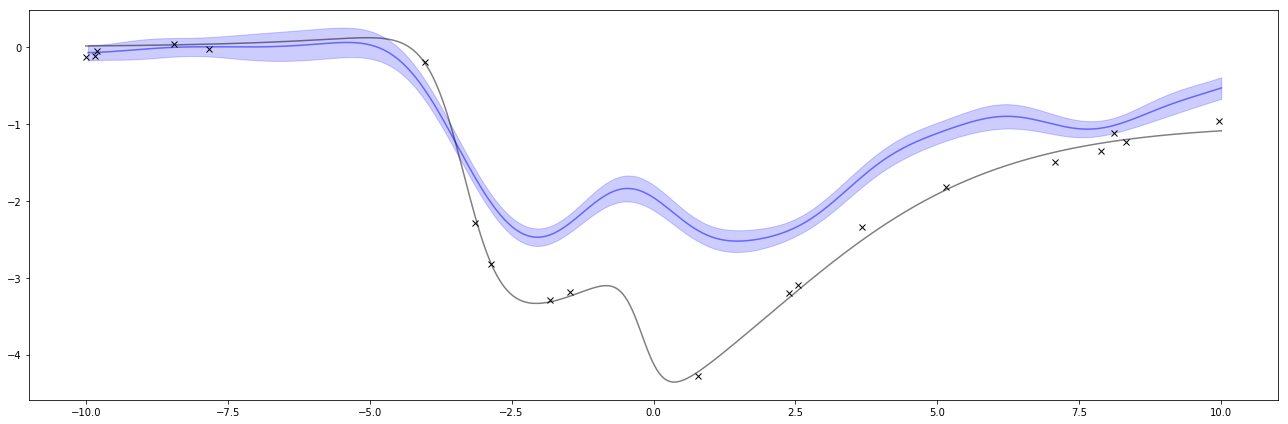

In [13]:
mu, cov = posterior(unobserved_xs, observed_xs, observed_ys, ell=1, sigma_f=0.1)
bottom, top = upper_lower_bounds(mu, cov)

plt.figure(figsize=(18, 6))

plt.plot(all_xs, f(all_xs), '-k', alpha=0.5)
plt.plot(unobserved_xs, mu, '-b', alpha=0.5)
plt.fill_between(unobserved_xs, bottom, top, color='blue', alpha=0.2)
plt.plot(observed_xs, observed_ys, 'xk')
maybe_save_plot('2018-05-18-poor-prediction')
plt.show()